In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install albumentations==0.4.6
!pip uninstall -y opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 27.4 MB/s 
     |████████████████████████████████| 948 kB 61.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=8bf03554f1505aa67dae5a1b81f96df8b7b629d3ae0b7c3ecd1c8aac7d95aaab
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import traceback
import itertools

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from sklearn.metrics import confusion_matrix

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt

In [ ]:
good_images = ['10_0_0_69870_475548_6.130.26.01', '10_0_1_69870_475498_6.131.27.11', '10_0_2_69870_475518_6.131.27.16', '10_0_3_69870_475498_6.131.27.11', '10_0_3_69870_475518_6.131.27.16', '10_0_3_69870_475550_6.130.26.02', '10_0_4_69870_475498_6.131.27.11', '10_0_4_69870_475518_6.131.27.16', '10_0_4_69870_475550_6.130.26.02', '10_0_7_69870_475498_6.131.27.11', '10_0_7_69870_475518_6.131.27.16', '10_0_8_69870_475498_6.131.27.11', '10_0_8_69870_475550_6.130.26.02', '10_0_8_69870_475554_6.130.26.04', '10_0_9_69870_475554_6.130.26.04', '10_1_0_69870_475498_6.131.27.11', '10_1_0_69870_475518_6.131.27.16', '10_1_1_69870_475498_6.131.27.11', '10_1_2_69870_475518_6.131.27.16', '10_1_3_69870_475548_6.130.26.01', '10_1_4_69870_475518_6.131.27.16', '10_1_8_69870_475554_6.130.26.04', '10_1_9_69870_475518_6.131.27.16', '10_2_0_69870_475498_6.131.27.11', '10_2_0_69870_475548_6.130.26.01', '10_2_2_69870_475498_6.131.27.11', '10_2_4_69870_475518_6.131.27.16', '10_2_6_69870_475518_6.131.27.16', '10_2_6_69870_475554_6.130.26.04', '10_2_7_69870_475518_6.131.27.16', '10_2_8_69870_475498_6.131.27.11', '10_2_8_69870_475518_6.131.27.16', '10_2_8_69870_475554_6.130.26.04', '10_2_9_69870_475518_6.131.27.16', '10_3_0_69870_475548_6.130.26.01', '10_3_1_69870_475518_6.131.27.16', '10_3_2_69870_475518_6.131.27.16', '10_3_3_69870_475518_6.131.27.16', '10_3_3_69870_475548_6.130.26.01', '10_3_4_69870_475498_6.131.27.11', '10_3_4_69870_475518_6.131.27.16', '10_3_5_69870_475498_6.131.27.11', '10_3_7_69870_475518_6.131.27.16', '10_3_7_69870_475554_6.130.26.04', '10_3_8_69870_475554_6.130.26.04', '10_3_9_69870_475554_6.130.26.04', '10_4_1_69870_475518_6.131.27.16', '10_4_1_69870_475548_6.130.26.01', '10_4_4_69870_475498_6.131.27.11', '10_4_5_69870_475498_6.131.27.11', '10_4_5_69870_475550_6.130.26.02', '10_4_6_69870_475498_6.131.27.11', '10_4_7_69870_475518_6.131.27.16', '10_5_1_69870_475554_6.130.26.04', '10_5_3_69870_475498_6.131.27.11', '10_5_3_69870_475518_6.131.27.16', '10_5_4_69870_475498_6.131.27.11', '10_5_6_69870_475498_6.131.27.11', '10_5_9_69870_475554_6.130.26.04', '10_6_0_69870_475548_6.130.26.01', '10_6_0_69870_475554_6.130.26.04', '10_6_2_69870_475518_6.131.27.16', '10_6_2_69870_475554_6.130.26.04', '10_6_3_69870_475518_6.131.27.16', '10_6_3_69870_475554_6.130.26.04', '10_6_5_69870_475550_6.130.26.02', '10_6_5_69870_475554_6.130.26.04', '10_6_6_69870_475550_6.130.26.02', '10_6_8_69870_475518_6.131.27.16', '10_6_8_69870_475554_6.130.26.04', '10_6_9_69870_475518_6.131.27.16', '10_6_9_69870_475550_6.130.26.02', '10_7_0_69870_475548_6.130.26.01', '10_7_1_69870_475518_6.131.27.16', '10_7_1_69870_475548_6.130.26.01', '10_7_2_69870_475518_6.131.27.16', '10_7_3_69870_475518_6.131.27.16', '10_7_5_69870_475518_6.131.27.16', '10_7_5_69870_475554_6.130.26.04', '10_7_6_69870_475518_6.131.27.16', '10_7_6_69870_475554_6.130.26.04', '10_7_7_69870_475518_6.131.27.16', '10_7_7_69870_475554_6.130.26.04', '10_7_9_69870_475518_6.131.27.16', '10_8_0_69870_475548_6.130.26.01', '10_8_1_69870_475518_6.131.27.16', '10_8_2_69870_475518_6.131.27.16', '10_8_2_69870_475554_6.130.26.04', '10_8_3_69870_475498_6.131.27.11', '10_8_3_69870_475554_6.130.26.04', '10_8_4_69870_475518_6.131.27.16', '10_8_5_69870_475548_6.130.26.01', '10_8_8_69870_475550_6.130.26.02', '10_8_8_69870_475554_6.130.26.04', '10_9_2_69870_475554_6.130.26.04', '10_9_3_69870_475548_6.130.26.01', '10_9_5_69870_475554_6.130.26.04', '10_9_6_69870_475554_6.130.26.04', '10_9_7_69870_475518_6.131.27.16', '10_9_7_69870_475554_6.130.26.04', '2_0_0_64919_430994_6.132.26.25', '2_0_0_64919_431029_6.131.27.06', '3_0_0_70103_773750_6.130.26.01.1.3', '3_0_0_70103_773794_6.130.26.03.1.1', '3_0_0_70103_773799_6.130.26.04.1.2', '3_0_0_70103_773910_6.131.26.25.1.4', '3_0_0_70103_773913_6.131.27.21.1.3', '3_0_0_70103_773914_6.131.27.21.1.4', '3_0_0_70103_773951_6.131.27.21.1.2', '3_0_0_70103_774253_6.131.27.12.1.1', '3_0_1_70103_773786_6.130.26.01.1.1', '3_0_1_70103_773801_6.130.26.04.2.2', '3_0_1_70103_773911_6.131.26.25.2.3', '3_0_1_70103_773951_6.131.27.21.1.2', '3_0_1_70103_773988_6.131.27.16.3.4', '3_0_1_70103_774533_6.132.26.25.1.1', '3_0_2_70103_773722_6.130.26.02.4.2', '3_1_0_70103_773794_6.130.26.03.1.1', '3_1_0_70103_774383_6.131.27.06.1.1', '3_1_1_70103_773875_6.131.26.25.3.2', '3_1_1_70103_773913_6.131.27.21.1.3', '3_1_1_70103_774176_6.131.27.11.4.2', '3_1_1_70103_774253_6.131.27.12.1.1', '3_1_2_70103_773722_6.130.26.02.4.2', '3_2_0_70103_773786_6.130.26.01.1.1', '3_2_0_70103_773910_6.131.26.25.1.4', '3_2_0_70103_773988_6.131.27.16.3.4', '3_2_0_70103_774064_6.131.27.16.2.4', '3_2_0_70103_774533_6.132.26.25.1.1', '3_2_0_73131_879365_M-34-50-C-a-4-4', '3_2_1_70103_773750_6.130.26.01.1.3', '3_2_1_70103_773759_6.130.26.03.1.4', '3_2_1_70103_773786_6.130.26.01.1.1', '3_2_1_70103_773801_6.130.26.04.2.2', '3_2_1_70103_773875_6.131.26.25.3.2', '3_2_1_70103_773910_6.131.26.25.1.4', '3_2_1_70103_773911_6.131.26.25.2.3', '3_2_1_70103_773988_6.131.27.16.3.4', '3_2_1_70103_774064_6.131.27.16.2.4', '3_2_1_70103_774138_6.131.27.11.4.4', '3_2_1_70103_774176_6.131.27.11.4.2', '3_2_1_73131_879365_M-34-50-C-a-4-4', '3_2_2_70103_773750_6.130.26.01.1.3', '3_2_2_70103_773913_6.131.27.21.1.3', '3_2_2_70103_773914_6.131.27.21.1.4', '3_2_2_70103_774176_6.131.27.11.4.2', '3_2_2_70103_774253_6.131.27.12.1.1', '3_2_2_70103_774383_6.131.27.06.1.1', '3_2_2_70103_774533_6.132.26.25.1.1', '5_0_0_73738_924283_6.130.26.02.4', '5_0_0_73738_924304_6.130.26.03.2', '5_0_0_73738_924324_6.131.26.24.3', '5_0_0_73738_924326_6.131.26.25.3', '5_0_0_73738_924327_6.131.26.25.4', '5_0_0_73738_924346_6.131.26.25.2', '5_0_0_73738_924347_6.131.27.21.1', '5_0_0_73738_924366_6.131.27.16.3', '5_0_0_73738_924367_6.131.27.16.4', '5_0_0_73738_924427_6.131.27.12.1', '5_0_1_73738_924324_6.131.26.24.3', '5_0_1_73738_924345_6.131.26.25.1', '5_0_1_73738_924346_6.131.26.25.2', '5_0_1_73738_924347_6.131.27.21.1', '5_0_1_73738_924366_6.131.27.16.3', '5_0_1_73738_924367_6.131.27.16.4', '5_0_1_73738_924427_6.131.27.12.1', '5_0_2_73738_924305_6.130.26.04.1', '5_0_2_73738_924327_6.131.26.25.4', '5_0_2_73738_924347_6.131.27.21.1', '5_0_2_73738_924366_6.131.27.16.3', '5_0_2_73738_924367_6.131.27.16.4', '5_0_3_73738_924303_6.130.26.03.1', '5_0_3_73738_924325_6.131.26.24.4', '5_0_3_73738_924327_6.131.26.25.4', '5_0_3_73738_924345_6.131.26.25.1', '5_0_3_73738_924347_6.131.27.21.1', '5_0_3_73738_924366_6.131.27.16.3', '5_0_4_73738_924283_6.130.26.02.4', '5_0_4_73738_924303_6.130.26.03.1', '5_0_4_73738_924304_6.130.26.03.2', '5_0_4_73738_924306_6.130.26.04.2', '5_0_4_73738_924327_6.131.26.25.4', '5_0_4_73738_924345_6.131.26.25.1', '5_0_4_73738_924346_6.131.26.25.2', '5_0_4_73738_924347_6.131.27.21.1', '5_0_4_73738_924366_6.131.27.16.3', '5_0_4_73738_924367_6.131.27.16.4', '5_1_0_73738_924304_6.130.26.03.2', '5_1_0_73738_924326_6.131.26.25.3', '5_1_0_73738_924345_6.131.26.25.1', '5_1_0_73738_924346_6.131.26.25.2', '5_1_0_73738_924347_6.131.27.21.1', '5_1_0_73738_924366_6.131.27.16.3', '5_1_0_73738_924367_6.131.27.16.4', '5_1_1_73738_924304_6.130.26.03.2', '5_1_1_73738_924324_6.131.26.24.3', '5_1_1_73738_924326_6.131.26.25.3', '5_1_1_73738_924345_6.131.26.25.1', '5_1_1_73738_924347_6.131.27.21.1', '5_1_1_73738_924366_6.131.27.16.3', '5_1_1_73738_924367_6.131.27.16.4', '5_1_2_73738_924305_6.130.26.04.1', '5_1_2_73738_924327_6.131.26.25.4', '5_1_2_73738_924347_6.131.27.21.1', 
'5_1_2_73738_924366_6.131.27.16.3', '5_1_2_73738_924367_6.131.27.16.4', '5_1_3_73738_924299_6.130.26.01.1', '5_1_3_73738_924303_6.130.26.03.1', '5_1_3_73738_924304_6.130.26.03.2', '5_1_3_73738_924306_6.130.26.04.2', '5_1_3_73738_924327_6.131.26.25.4', '5_1_3_73738_924347_6.131.27.21.1', '5_1_3_73738_924366_6.131.27.16.3', '5_1_3_73738_924367_6.131.27.16.4', '5_1_3_73738_924406_6.131.27.11.4', '5_1_4_73738_924283_6.130.26.02.4', '5_1_4_73738_924303_6.130.26.03.1', '5_1_4_73738_924306_6.130.26.04.2', '5_1_4_73738_924325_6.131.26.24.4', '5_1_4_73738_924345_6.131.26.25.1', '5_1_4_73738_924347_6.131.27.21.1', '5_1_4_73738_924366_6.131.27.16.3', '5_1_4_73738_924367_6.131.27.16.4', '5_1_4_73738_924386_6.131.27.16.2', '5_2_0_73738_924299_6.130.26.01.1', '5_2_0_73738_924304_6.130.26.03.2', '5_2_0_73738_924327_6.131.26.25.4', '5_2_0_73738_924345_6.131.26.25.1', '5_2_0_73738_924347_6.131.27.21.1', '5_2_0_73738_924366_6.131.27.16.3', '5_2_0_73738_924367_6.131.27.16.4', '5_2_1_73738_924347_6.131.27.21.1', '5_2_1_73738_924367_6.131.27.16.4', '5_2_2_73738_924281_6.130.26.01.4', '5_2_2_73738_924303_6.130.26.03.1', '5_2_2_73738_924304_6.130.26.03.2', '5_2_2_73738_924325_6.131.26.24.4', '5_2_2_73738_924345_6.131.26.25.1', '5_2_2_73738_924346_6.131.26.25.2', '5_2_2_73738_924347_6.131.27.21.1', '5_2_2_73738_924366_6.131.27.16.3', '5_2_2_73738_924367_6.131.27.16.4', '5_2_2_73738_924386_6.131.27.16.2', '5_2_3_73738_924306_6.130.26.04.2', '5_2_3_73738_924324_6.131.26.24.3', '5_2_3_73738_924326_6.131.26.25.3', '5_2_3_73738_924345_6.131.26.25.1', '5_2_3_73738_924347_6.131.27.21.1', '5_2_3_73738_924427_6.131.27.12.1', '5_2_4_73738_924302_6.130.26.02.2', '5_2_4_73738_924304_6.130.26.03.2', '5_2_4_73738_924346_6.131.26.25.2', '5_2_4_73738_924367_6.131.27.16.4', '5_2_4_73738_924386_6.131.27.16.2', '5_2_4_73738_924406_6.131.27.11.4', '5_2_4_73738_924427_6.131.27.12.1', '5_3_0_73738_924299_6.130.26.01.1', '5_3_0_73738_924303_6.130.26.03.1', '5_3_0_73738_924324_6.131.26.24.3', '5_3_0_73738_924326_6.131.26.25.3', '5_3_0_73738_924327_6.131.26.25.4', '5_3_0_73738_924346_6.131.26.25.2', '5_3_0_73738_924347_6.131.27.21.1', '5_3_0_73738_924366_6.131.27.16.3', '5_3_0_73738_924367_6.131.27.16.4', '5_3_1_73738_924299_6.130.26.01.1', '5_3_1_73738_924306_6.130.26.04.2', '5_3_1_73738_924325_6.131.26.24.4', '5_3_1_73738_924345_6.131.26.25.1', '5_3_1_73738_924346_6.131.26.25.2', '5_3_1_73738_924347_6.131.27.21.1', '5_3_1_73738_924366_6.131.27.16.3', '5_3_1_73738_924406_6.131.27.11.4', '5_3_1_73738_924427_6.131.27.12.1', '5_3_1_73738_924447_6.131.27.07.3', '5_3_2_73738_924281_6.130.26.01.4', '5_3_2_73738_924299_6.130.26.01.1', '5_3_2_73738_924306_6.130.26.04.2', '5_3_2_73738_924345_6.131.26.25.1', '5_3_2_73738_924347_6.131.27.21.1', '5_3_2_73738_924366_6.131.27.16.3', '5_3_2_73738_924386_6.131.27.16.2', '5_3_2_73738_924447_6.131.27.07.3', '5_3_3_73738_924300_6.130.26.01.2', '5_3_3_73738_924302_6.130.26.02.2', '5_3_3_73738_924327_6.131.26.25.4', '5_3_3_73738_924345_6.131.26.25.1', '5_3_3_73738_924346_6.131.26.25.2', '5_3_3_73738_924366_6.131.27.16.3', '5_3_3_73738_924367_6.131.27.16.4', '5_3_3_73738_924427_6.131.27.12.1', '5_3_4_73738_924302_6.130.26.02.2', '5_3_4_73738_924303_6.130.26.03.1', '5_3_4_73738_924325_6.131.26.24.4', '5_3_4_73738_924327_6.131.26.25.4', '5_3_4_73738_924345_6.131.26.25.1', '5_3_4_73738_924346_6.131.26.25.2', '5_3_4_73738_924347_6.131.27.21.1', '5_3_4_73738_924366_6.131.27.16.3', '5_3_4_73738_924386_6.131.27.16.2', '5_4_0_73738_924303_6.130.26.03.1', '5_4_0_73738_924305_6.130.26.04.1', '5_4_0_73738_924306_6.130.26.04.2', '5_4_0_73738_924327_6.131.26.25.4', '5_4_0_73738_924346_6.131.26.25.2', '5_4_0_73738_924347_6.131.27.21.1', '5_4_0_73738_924386_6.131.27.16.2', '5_4_0_73738_924406_6.131.27.11.4', '5_4_1_73738_924299_6.130.26.01.1', '5_4_1_73738_924306_6.130.26.04.2', '5_4_1_73738_924346_6.131.26.25.2', '5_4_1_73738_924347_6.131.27.21.1', '5_4_1_73738_924366_6.131.27.16.3', '5_4_1_73738_924367_6.131.27.16.4', '5_4_1_73738_924427_6.131.27.12.1', '5_4_2_73738_924324_6.131.26.24.3', '5_4_2_73738_924326_6.131.26.25.3', '5_4_2_73738_924345_6.131.26.25.1', '5_4_2_73738_924347_6.131.27.21.1', '5_4_2_73738_924366_6.131.27.16.3', '5_4_2_73738_924367_6.131.27.16.4', '5_4_2_73738_924386_6.131.27.16.2', '5_4_3_73738_924347_6.131.27.21.1', '5_4_3_73738_924366_6.131.27.16.3', '5_4_3_73738_924386_6.131.27.16.2', '5_4_4_73738_924281_6.130.26.01.4', '5_4_4_73738_924304_6.130.26.03.2', '5_4_4_73738_924327_6.131.26.25.4', '5_4_4_73738_924345_6.131.26.25.1', '5_4_4_73738_924346_6.131.26.25.2', '5_4_4_73738_924347_6.131.27.21.1', '5_4_4_73738_924366_6.131.27.16.3', '5_4_4_73738_924367_6.131.27.16.4', '5_4_4_73738_924386_6.131.27.16.2', '6_0_0_74837_1014603_6.132.26.25.1', '6_0_1_74837_1014603_6.132.26.25.1', '6_0_2_74837_1014603_6.132.26.25.1', '6_1_0_74837_1014603_6.132.26.25.1', '6_2_1_74837_1014603_6.132.26.25.1', '6_2_2_74837_1014603_6.132.26.25.1', '6_3_0_74837_1014603_6.132.26.25.1', '6_3_1_74837_1014603_6.132.26.25.1', '6_4_1_74837_1014603_6.132.26.25.1', '6_4_2_74837_1014603_6.132.26.25.1', '6_4_3_74837_1014603_6.132.26.25.1']

extension_good_images = [pathname + '.png' for pathname in good_images]

In [ ]:
pd.options.mode.chained_assignment = None

DIR_INPUT = '/content/drive/MyDrive/photos-dataset'
DIR_TRAIN = f'{DIR_INPUT}/test'
train_df = pd.read_csv(f'{DIR_INPUT}/test.csv')
train_df.shape

train_df['x'] = train_df['x'].astype(np.float16)
train_df['y'] = train_df['y'].astype(np.float16)
train_df['w'] = train_df['w'].astype(np.float16)
train_df['h'] = train_df['h'].astype(np.float16)

# sizes = []
# for entry in train_df["pathname"].unique():
# #     pathname = train_df["pathname"]
#     print(entry)
#     image = cv2.imread(f'{DIR_TRAIN}/{entry}', cv2.IMREAD_COLOR)
#     sizes.append(image.shape)

train_df = train_df.loc[train_df['pathname'].isin(extension_good_images)]
train_df = train_df.loc[~train_df['image_id'].isin([8544, 8536, 8543])]

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-10:]
train_ids = image_ids[:-10]

valid_df = train_df.loc[train_df['image_id'].isin(valid_ids)]
train_df = train_df.loc[train_df['image_id'].isin(train_ids)]

In [ ]:
def get_preds(boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray):
  output = [np.concatenate((np.array(box).astype(np.float16), np.array([score]).astype(np.float16), np.array([label]).astype(np.float16))) for box, score, label in zip(boxes, scores, labels)]
  return np.array(output)

def get_gt(boxes: np.ndarray, labels: np.ndarray):
  output = [np.concatenate((np.array([label]).astype(np.float16), np.array(box).astype(np.float16))) for box, score, label in zip(boxes, scores, labels)]
  return np.array(output)

def box_iou_calc(boxes1, boxes2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2

    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[0, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, 0] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes):
            print(' '.join(map(str, self.matrix[i])))

In [ ]:
class PhotosDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None, width=800, height=750):
        super().__init__()

        self.pathnames = dataframe['pathname'].unique()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.width = width
        self.height = height

    def __getitem__(self, index: int):
        
        newIndex = index - 1
        image_id = self.image_ids[newIndex]
        pathname = self.pathnames[newIndex]

        records = self.df[self.df['pathname'] == pathname]

        try:
          image = cv2.imread(f'{self.image_dir}/{pathname}', cv2.IMREAD_COLOR)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        except:
          raise Exception("Check this pathname: " + pathname)
        
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        image_resized_width = self.width
        image_resized_height = int(image_height * (self.width / image_width))
        
        image_resized = cv2.resize(image, (self.width,  image_resized_height),)
        image_resized /= 255.0

        
        records.loc[:, ['x', 'w']] *= self.width / image_width
        records.loc[:, ['y', 'h']] *= image_resized_height / image_height

        boxes = records[['x', 'y', 'w', 'h']].values
        
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2], 0, self.width)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3], 0, image_resized_height)
        boxes[:, 0] = np.clip(boxes[:, 0], 0, self.width - 1)
        boxes[:, 1] = np.clip(boxes[:, 1], 0, image_resized_height - 1)

        
        area = records['w'] * records['h']
        area = torch.as_tensor(area.values, dtype=torch.float32)

        labels = torch.tensor(records['category_id'].values)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['pathname'] = torch.tensor([newIndex])
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = torch.tensor([image_id])

        if self.transforms:
            sample = {
                'image': image_resized,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image_resized = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image_resized, target, pathname

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [42]:
def get_train_transform():
    return A.Compose([
        
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    

num_classes = 13  # 11 classes (wheat) + background
conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = 0.3, IOU_THRESHOLD = 0.5)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#RESEARCH 

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PhotosDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = PhotosDataset(valid_df, DIR_TRAIN, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.load_state_dict(torch.load(f"{DIR_INPUT}/26-06-2022-lr0_01-step100.pth", map_location=device))

1024


<All keys matched successfully>

In [43]:
model.eval()

colors = [(0, 0, 0), (225, 0, 225), (225, 255, 225), (225, 225, 0), (0, 0, 225), (225, 0, 0), "", (0, 225, 225), (125, 20, 127), (125, 0, 125), (0, 0, 125), (125, 0, 0), (0, 125, 0)]

for images, targets, image_ids in valid_data_loader:
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    correct_labels = targets[0]['labels'].cpu().detach().numpy().astype(np.int32)

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    # print(get_num_correct(outputs[0]['labels'].cpu().detach(), targets[0]['labels'].cpu().detach()))
    boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
    labels = outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().detach().numpy()
    scores = outputs[0]['scores'].cpu().detach().numpy().astype(np.float16)
    # print(scores)
    # print(np.block([boxes, [scores], [labels]]))
    preds = get_preds(boxes, scores, labels)
    gt_boxes = get_gt(boxes, labels)
    conf_mat.process_batch(preds, gt_boxes)
    # print(get_num_correct(outputs[0]['labels'], targets[0]['labels']))
    for i, box in enumerate(boxes):
        if scores[i] < 0.4:
            continue
        label = labels[i]
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 1)
        cv2.putText(sample, str(labels[i]), (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    ax.set_axis_off()
    ax.imshow(sample)
conf_mat.print_matrix()
classes = ["Tlo", "Budynek","Drzewo","Pojazd","WieleDrzew","CienieDrzew", "", "Skladowisko","Parking","PryzmaZiemi","Wykop","ZbiornikWodny","ParkingPolny"]

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Normalized confusion matrix
[[0.         0.12903226 0.35483871 0.03225806 0.16129032 0.18064516
  0.         0.03225806 0.05806452 0.03870968 0.         0.01290323
  0.        ]
 [0.07407407 0.92592593 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.13114754 0.         0.         0.         0.86885246 0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.06666667 0.   

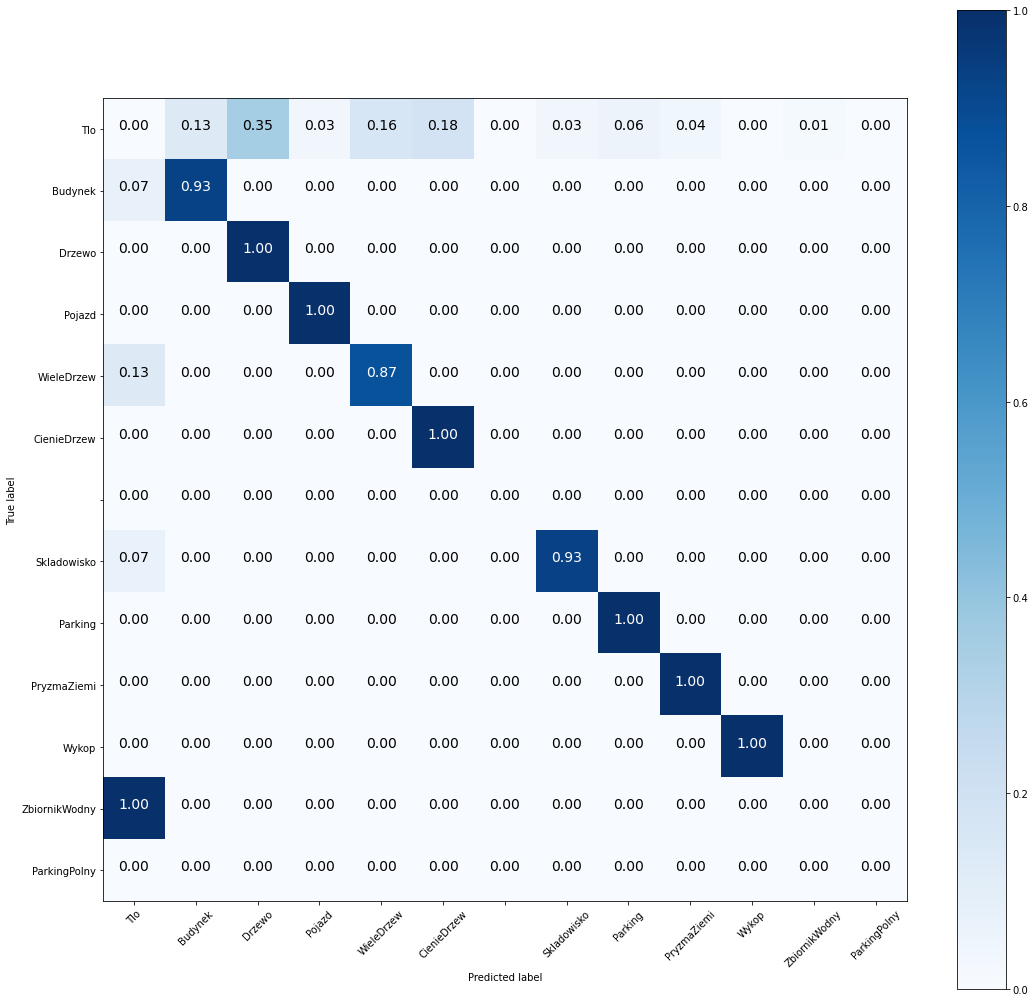

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], nan=0.0)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(18, 18))
    grid = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # fig.title(title)
    fig.colorbar(grid)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=14, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_mat.return_matrix(), classes)

In [44]:
model.load_state_dict(torch.load(f"{DIR_INPUT}/26-06-2022-lr0_01-step100_final.pth", map_location=device))
model.eval()
for images, targets, image_ids in valid_data_loader:
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
    labels = outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().detach().numpy()
    scores = outputs[0]['scores'].cpu().detach().numpy().astype(np.float16)
    # y_pred.extend(labels)
    # y_true.extend(targets[0]['labels'].cpu().detach().numpy().astype(np.int32))
    
    for i, box in enumerate(boxes):
        if scores[i] < 0.3:
            continue
        label = labels[i]
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 1)
        cv2.putText(sample, str(label), (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    ax.set_axis_off()
    ax.imshow(sample)

Output hidden; open in https://colab.research.google.com to view.

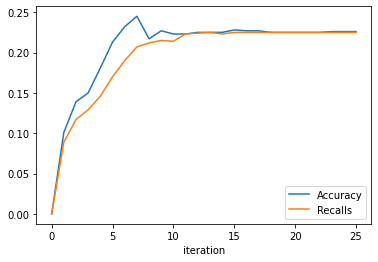

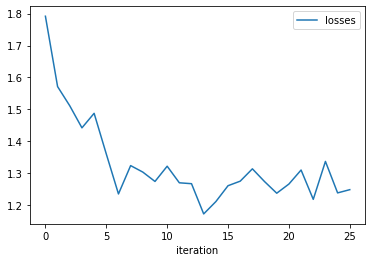

In [54]:
#26-06-2022-lr0_01-step5
accuracies = [0, 0.101, 0.139, 0.15, 0.181, 0.213, 0.232, 0.245, 0.217, 0.227, 0.223, 0.223, 0.225, 0.225, 0.225, 0.228, 0.227, 0.227, 0.225, 0.225, 0.225, 0.225, 0.225, 0.226, 0.226, 0.226]
recalls = [0, 0.089, 0.117, 0.129, 0.146, 0.17, 0.19, 0.207, 0.212, 0.215, 0.214, 0.223, 0.224, 0.225, 0.223, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225]
losses = [1.7916,1.5714,1.5113,1.4423,1.4878,1.3605,1.2354,1.3241,1.3038,1.2745,1.3222,1.2703,1.2675,1.1729,1.2115,1.2612,1.2754,1.3140,1.2741,1.2377,1.2664,1.3103,1.2185,1.3372,1.2387,1.2488]
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()
# plt.plot(range(len(accuracies)), accuracies)
# plt.plot(range(len(recalls)), recalls)

0.37


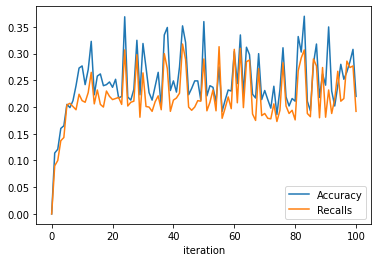

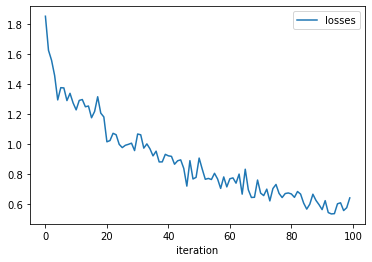

In [57]:
#26-06-2022-lr0_01-step100
recalls = [0, 0.09, 0.1, 0.137, 0.143, 0.204, 0.207, 0.201, 0.195, 0.224, 0.212, 0.209, 0.227, 0.265, 0.206, 0.232, 0.205, 0.2, 0.23, 0.22, 0.214, 0.216, 0.218, 0.205, 0.307, 0.202, 0.209, 0.211, 0.298, 0.181, 0.264, 0.201, 0.2, 0.192, 0.21, 0.221, 0.195, 0.3, 0.272, 0.192, 0.213, 0.217, 0.226, 0.318, 0.289, 0.2, 0.194, 0.2, 0.212, 0.211, 0.29, 0.193, 0.209, 0.232, 0.193, 0.313, 0.179, 0.198, 0.219, 0.197, 0.308, 0.208, 0.31, 0.199, 0.285, 0.288, 0.187, 0.175, 0.272, 0.184, 0.188, 0.179, 0.178, 0.206, 0.173, 0.194, 0.283, 0.202, 0.188, 0.194, 0.176, 0.268, 0.292, 0.307, 0.188, 0.182, 0.29, 0.277, 0.18, 0.274, 0.181, 0.232, 0.188, 0.215, 0.267, 0.211, 0.216, 0.286, 0.274, 0.277, 0.192]
accuracies = [0, 0.114, 0.121, 0.16, 0.165, 0.205, 0.199, 0.212, 0.24, 0.273, 0.277, 0.242, 0.27, 0.323, 0.223, 0.258, 0.262, 0.24, 0.242, 0.247, 0.237, 0.252, 0.217, 0.22, 0.369, 0.219, 0.213, 0.233, 0.325, 0.223, 0.319, 0.274, 0.227, 0.213, 0.239, 0.265, 0.2, 0.335, 0.349, 0.231, 0.249, 0.228, 0.275, 0.352, 0.321, 0.223, 0.235, 0.249, 0.249, 0.213, 0.36, 0.221, 0.24, 0.237, 0.21, 0.275, 0.192, 0.213, 0.232, 0.23, 0.304, 0.244, 0.335, 0.223, 0.312, 0.298, 0.224, 0.217, 0.3, 0.214, 0.231, 0.214, 0.198, 0.239, 0.186, 0.233, 0.311, 0.219, 0.202, 0.216, 0.211, 0.332, 0.303, 0.37, 0.211, 0.193, 0.281, 0.318, 0.218, 0.262, 0.241, 0.35, 0.23, 0.202, 0.24, 0.28, 0.252, 0.266, 0.285, 0.308, 0.22]
losses = [1.8527,1.6257,1.5592,1.4575,1.2955,1.3771,1.3754,1.2910,1.3395,1.2756,1.2292,1.2921,1.2981,1.2499,1.2548,1.1767,1.2186,1.3166,1.2077,1.1821,1.0165,1.0248,1.0731,1.0636,0.9996,0.9779,0.9934,0.9997,1.0074,0.9581,1.0685,1.0632,0.9744,1.0026,0.9701,0.9227,0.9541,0.8825,0.8828,0.9331,0.9231,0.9197,0.8671,0.8900,0.8963,0.8394,0.7215,0.8910,0.7690,0.7797,0.9082,0.8351,0.7670,0.7726,0.7655,0.8067,0.7692,0.7061,0.7826,0.7163,0.7705,0.7762,0.7411,0.8015,0.6680,0.8339,0.6968,0.6458,0.6472,0.7619,0.6749,0.6583,0.7013,0.6229,0.7053,0.7325,0.6728,0.6453,0.6719,0.6759,0.6693,0.6467,0.6855,0.6682,0.6081,0.5682,0.6014,0.6675,0.6265,0.5978,0.5650,0.6247,0.5453,0.5363,0.5381,0.6036,0.6104,0.5587,0.5777,0.6430]
# print(max(accuracies))
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()

0.354


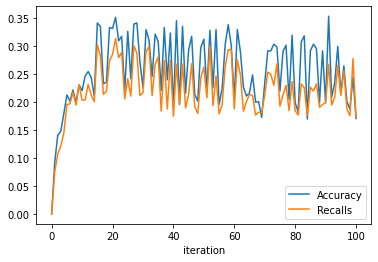

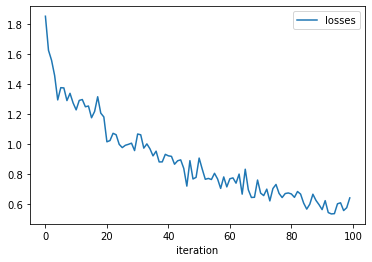

In [59]:
#26-06-2022-lr0_01-step100
recalls = [0, 0.075, 0.107, 0.122, 0.145, 0.196, 0.197, 0.218, 0.195, 0.231, 0.204, 0.204, 0.232, 0.213, 0.201, 0.303, 0.283, 0.214, 0.22, 0.274, 0.286, 0.314, 0.28, 0.289, 0.206, 0.242, 0.211, 0.301, 0.288, 0.212, 0.217, 0.291, 0.3, 0.212, 0.268, 0.281, 0.184, 0.275, 0.188, 0.275, 0.175, 0.268, 0.197, 0.268, 0.19, 0.214, 0.269, 0.192, 0.18, 0.244, 0.263, 0.208, 0.301, 0.194, 0.247, 0.179, 0.195, 0.263, 0.294, 0.294, 0.188, 0.276, 0.249, 0.184, 0.201, 0.214, 0.212, 0.177, 0.182, 0.181, 0.213, 0.254, 0.25, 0.23, 0.269, 0.193, 0.213, 0.23, 0.185, 0.237, 0.185, 0.177, 0.233, 0.226, 0.176, 0.227, 0.22, 0.233, 0.191, 0.196, 0.199, 0.268, 0.195, 0.209, 0.266, 0.212, 0.256, 0.188, 0.176, 0.278, 0.174]
accuracies = [0, 0.092, 0.141, 0.148, 0.18, 0.213, 0.202, 0.222, 0.199, 0.231, 0.221, 0.247, 0.255, 0.244, 0.211, 0.342, 0.336, 0.233, 0.236, 0.334, 0.332, 0.352, 0.31, 0.318, 0.219, 0.327, 0.242, 0.34, 0.342, 0.272, 0.227, 0.33, 0.311, 0.246, 0.322, 0.309, 0.221, 0.334, 0.24, 0.324, 0.189, 0.346, 0.196, 0.336, 0.216, 0.294, 0.318, 0.214, 0.202, 0.298, 0.313, 0.22, 0.329, 0.226, 0.33, 0.196, 0.224, 0.303, 0.339, 0.302, 0.206, 0.33, 0.291, 0.227, 0.211, 0.217, 0.249, 0.2, 0.201, 0.173, 0.234, 0.292, 0.292, 0.304, 0.299, 0.22, 0.291, 0.302, 0.205, 0.32, 0.199, 0.183, 0.308, 0.319, 0.17, 0.292, 0.304, 0.296, 0.199, 0.292, 0.199, 0.354, 0.209, 0.235, 0.3, 0.215, 0.265, 0.201, 0.188, 0.245, 0.171]
loss = [2.3998,1.6809,1.5435,1.4988,1.4549,1.4087,1.3745,1.3466,1.3380,1.3124,1.2784,1.2569,1.2611,1.2376,1.2218,1.1926,1.1808,1.1549,1.1495,1.1370,1.1200,1.0991,1.0998,1.0828,1.0708,1.0624,1.0659,1.0300,1.0344,1.0156,0.9925,1.0035,0.9828,0.9650,0.9484,0.9361,0.9510,0.9273,0.9070,0.9113,0.9292,0.8945,0.8819,0.8719,0.8740,0.8627,0.8494,0.8411,0.8401,0.8229,0.8299,0.8093,0.7971,0.8066,0.7921,0.7859,0.7717,0.7633,0.7633,0.7540,0.7475,0.7336,0.7331,0.7251,0.7283,0.7180,0.7184,0.7101,0.6997,0.6908,0.6951,0.6806,0.6656,0.6722,0.6714,0.6587,0.6597,0.6646,0.6382,0.6457,0.6345,0.6240,0.6243,0.6339,0.6415,0.6204,0.6221,0.6219,0.6055,0.6065,0.5947,0.6003,0.5935,0.5810,0.5900,0.5836,0.5845,0.5700,0.5747,0.5875]

print(max(accuracies))
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()


0.359


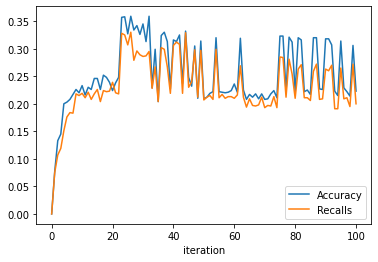

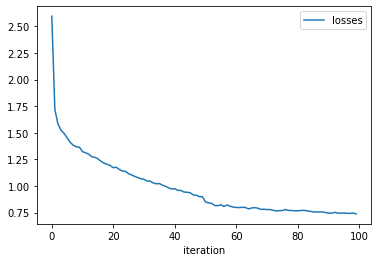

In [2]:
recalls = [0, 0.075, 0.107, 0.119, 0.151, 0.176, 0.184, 0.183, 0.218, 0.215, 0.219, 0.211, 0.221, 0.208, 0.218, 0.226, 0.204, 0.224, 0.222, 0.223, 0.239, 0.22, 0.218, 0.328, 0.325, 0.307, 0.33, 0.279, 0.296, 0.289, 0.286, 0.287, 0.295, 0.228, 0.267, 0.204, 0.302, 0.299, 0.267, 0.219, 0.306, 0.312, 0.308, 0.219, 0.329, 0.23, 0.24, 0.298, 0.212, 0.297, 0.207, 0.212, 0.215, 0.208, 0.299, 0.211, 0.217, 0.21, 0.213, 0.213, 0.21, 0.216, 0.269, 0.212, 0.194, 0.209, 0.197, 0.196, 0.198, 0.212, 0.193, 0.197, 0.196, 0.213, 0.193, 0.285, 0.284, 0.212, 0.281, 0.254, 0.21, 0.263, 0.271, 0.211, 0.211, 0.206, 0.259, 0.272, 0.208, 0.209, 0.263, 0.26, 0.27, 0.191, 0.191, 0.265, 0.209, 0.211, 0.195, 0.272, 0.2]
accuracies = [0, 0.077, 0.133, 0.145, 0.2, 0.203, 0.208, 0.217, 0.226, 0.22, 0.233, 0.216, 0.23, 0.226, 0.246, 0.246, 0.226, 0.252, 0.248, 0.239, 0.224, 0.238, 0.248, 0.357, 0.358, 0.327, 0.359, 0.334, 0.342, 0.326, 0.345, 0.313, 0.359, 0.229, 0.299, 0.204, 0.324, 0.33, 0.313, 0.227, 0.316, 0.313, 0.325, 0.237, 0.332, 0.248, 0.232, 0.305, 0.21, 0.314, 0.209, 0.212, 0.219, 0.222, 0.32, 0.222, 0.221, 0.22, 0.221, 0.224, 0.236, 0.221, 0.319, 0.225, 0.208, 0.217, 0.212, 0.218, 0.209, 0.218, 0.208, 0.209, 0.218, 0.224, 0.211, 0.323, 0.323, 0.222, 0.321, 0.312, 0.222, 0.32, 0.316, 0.222, 0.225, 0.217, 0.32, 0.32, 0.227, 0.226, 0.318, 0.318, 0.307, 0.223, 0.215, 0.314, 0.229, 0.222, 0.214, 0.306, 0.223]
losses = [2.5958,1.7184,1.5842,1.5244,1.4953,1.4525,1.4104,1.3832,1.3688,1.3648,1.3228,1.3130,1.2989,1.2761,1.2701,1.2557,1.2325,1.2155,1.2035,1.1929,1.1722,1.1761,1.1551,1.1413,1.1378,1.1152,1.1040,1.0903,1.0791,1.0692,1.0633,1.0472,1.0472,1.0290,1.0210,1.0233,1.0078,0.9974,0.9832,0.9720,0.9750,0.9599,0.9582,0.9439,0.9411,0.9375,0.9170,0.9132,0.9006,0.8990,0.8502,0.8423,0.8368,0.8167,0.8156,0.8237,0.8079,0.8216,0.8099,0.8023,0.7985,0.7979,0.8000,0.7981,0.7850,0.7938,0.7972,0.7922,0.7804,0.7827,0.7783,0.7791,0.7718,0.7660,0.7692,0.7695,0.7796,0.7704,0.7707,0.7664,0.7678,0.7696,0.7718,0.7673,0.7626,0.7570,0.7564,0.7566,0.7568,0.7511,0.7460,0.7445,0.7527,0.7466,0.7447,0.7467,0.7442,0.7426,0.7461,0.7380]

print(max(accuracies))
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()


0.359


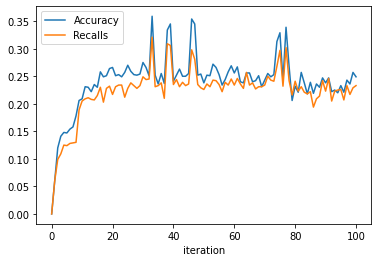

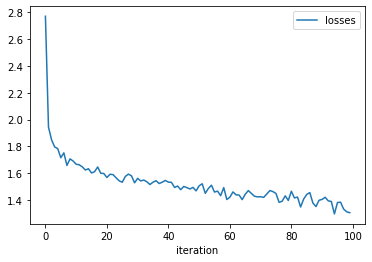

In [3]:
recalls = [0, 0.06, 0.099, 0.109, 0.125, 0.124, 0.128, 0.129, 0.13, 0.189, 0.205, 0.209, 0.211, 0.208, 0.207, 0.215, 0.23, 0.203, 0.228, 0.232, 0.217, 0.231, 0.234, 0.234, 0.212, 0.228, 0.238, 0.233, 0.228, 0.233, 0.249, 0.244, 0.245, 0.321, 0.231, 0.233, 0.238, 0.21, 0.309, 0.306, 0.235, 0.244, 0.231, 0.239, 0.233, 0.236, 0.298, 0.281, 0.235, 0.229, 0.226, 0.236, 0.231, 0.243, 0.242, 0.235, 0.222, 0.239, 0.234, 0.245, 0.234, 0.246, 0.236, 0.228, 0.257, 0.234, 0.238, 0.227, 0.231, 0.231, 0.234, 0.25, 0.243, 0.241, 0.268, 0.297, 0.232, 0.302, 0.242, 0.216, 0.241, 0.223, 0.231, 0.221, 0.218, 0.222, 0.194, 0.209, 0.214, 0.242, 0.223, 0.246, 0.205, 0.223, 0.225, 0.226, 0.207, 0.233, 0.217, 0.229, 0.233]
accuracies = [0, 0.06, 0.12, 0.141, 0.148, 0.147, 0.154, 0.158, 0.178, 0.206, 0.209, 0.231, 0.23, 0.222, 0.235, 0.23, 0.258, 0.249, 0.251, 0.264, 0.266, 0.251, 0.253, 0.249, 0.257, 0.27, 0.259, 0.253, 0.252, 0.254, 0.275, 0.266, 0.251, 0.359, 0.252, 0.236, 0.255, 0.237, 0.334, 0.345, 0.241, 0.252, 0.263, 0.25, 0.25, 0.255, 0.354, 0.345, 0.252, 0.254, 0.238, 0.252, 0.251, 0.272, 0.266, 0.253, 0.234, 0.244, 0.258, 0.269, 0.256, 0.267, 0.24, 0.238, 0.256, 0.256, 0.24, 0.242, 0.251, 0.231, 0.243, 0.255, 0.249, 0.253, 0.313, 0.329, 0.242, 0.339, 0.268, 0.206, 0.232, 0.221, 0.257, 0.238, 0.218, 0.239, 0.219, 0.236, 0.23, 0.247, 0.238, 0.247, 0.222, 0.225, 0.22, 0.233, 0.221, 0.243, 0.236, 0.257, 0.249]
losses = [2.7696, 1.9433, 1.8488, 1.7959, 1.7832, 1.7155, 1.7513, 1.6577, 1.7066, 1.6908, 1.6667, 1.6627, 1.6470, 1.6237, 1.6330, 1.6016, 1.6113, 1.6465, 1.5993, 1.5977, 1.5678, 1.5919, 1.5892, 1.5653, 1.5429, 1.5327, 1.5762, 1.5930, 1.5800, 1.5284, 1.5615, 1.5423, 1.5490, 1.5357, 1.5155, 1.5329, 1.5437, 1.5230, 1.5330, 1.5459, 1.5334, 1.5316, 1.4938, 1.5041, 1.4771, 1.5011, 1.4926, 1.4823, 1.4942, 1.4683, 1.5059, 1.5211, 1.4498, 1.4858, 1.5104, 1.4594, 1.4662, 1.4324, 1.4927, 1.4040, 1.4211, 1.4605, 1.4387, 1.4370, 1.4030, 1.4432, 1.4704, 1.4492, 1.4282, 1.4235, 1.4247, 1.4198, 1.4449, 1.4706, 1.4629, 1.4487, 1.3828, 1.3911, 1.4311, 1.3968, 1.4654, 1.4155, 1.4220, 1.3481, 1.4076, 1.4417, 1.4555, 1.3776, 1.3513, 1.3982, 1.4048, 1.4205, 1.3937, 1.3893, 1.2965, 1.3814, 1.3839, 1.3325, 1.3121, 1.3057]

print(max(accuracies))
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()


0.376


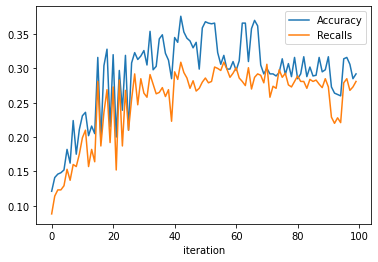

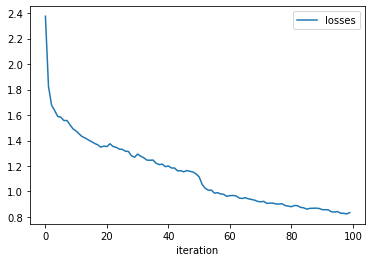

In [4]:
losses = [2.3759,1.8250,1.6782,1.6352,1.5895,1.5839,1.5570,1.5577,1.5235,1.4911,1.4750,1.4513,1.4299,1.4196,1.4042,1.3918,1.3773,1.3667,1.3479,1.3563,1.3527,1.3749,1.3532,1.3470,1.3328,1.3309,1.3164,1.3140,1.2802,1.2692,1.2939,1.2769,1.2647,1.2464,1.2452,1.2471,1.2225,1.2111,1.2146,1.1952,1.2001,1.1847,1.1841,1.1618,1.1632,1.1546,1.1642,1.1586,1.1529,1.1380,1.1150,1.0551,1.0245,1.0100,1.0106,0.9870,0.9909,0.9807,0.9775,0.9612,0.9679,0.9686,0.9657,0.9492,0.9450,0.9516,0.9428,0.9379,0.9322,0.9224,0.9187,0.9225,0.9073,0.9083,0.9093,0.9016,0.9019,0.9034,0.8893,0.8852,0.8807,0.8903,0.8885,0.8756,0.8716,0.8617,0.8675,0.8686,0.8694,0.8670,0.8577,0.8568,0.8561,0.8411,0.8387,0.8426,0.8294,0.8292,0.8240,0.8344]
accuracies = [0.121, 0.141, 0.146, 0.148, 0.152, 0.182, 0.162, 0.224, 0.175, 0.211, 0.231, 0.236, 0.202, 0.216, 0.205, 0.316, 0.195, 0.304, 0.328, 0.215, 0.320, 0.200, 0.297, 0.239, 0.319, 0.210, 0.308, 0.323, 0.313, 0.318, 0.326, 0.305, 0.354, 0.298, 0.303, 0.343, 0.349, 0.322, 0.312, 0.285, 0.345, 0.338, 0.376, 0.353, 0.344, 0.340, 0.330, 0.338, 0.299, 0.359, 0.368, 0.366, 0.365, 0.366, 0.323, 0.306, 0.319, 0.299, 0.299, 0.310, 0.297, 0.311, 0.366, 0.366, 0.310, 0.358, 0.370, 0.362, 0.305, 0.292, 0.300, 0.292, 0.292, 0.289, 0.294, 0.314, 0.291, 0.307, 0.288, 0.316, 0.285, 0.292, 0.317, 0.288, 0.302, 0.289, 0.290, 0.316, 0.295, 0.298, 0.317, 0.273, 0.264, 0.262, 0.260, 0.314, 0.316, 0.306, 0.285, 0.292]
recalls = [0.088, 0.114, 0.123, 0.123, 0.129, 0.153, 0.137, 0.160, 0.157, 0.175, 0.199, 0.210, 0.157, 0.182, 0.164, 0.281, 0.187, 0.236, 0.269, 0.192, 0.273, 0.152, 0.283, 0.187, 0.268, 0.210, 0.255, 0.292, 0.247, 0.285, 0.264, 0.258, 0.291, 0.277, 0.263, 0.265, 0.272, 0.259, 0.269, 0.223, 0.295, 0.284, 0.309, 0.294, 0.286, 0.271, 0.282, 0.267, 0.271, 0.280, 0.286, 0.279, 0.281, 0.302, 0.300, 0.297, 0.309, 0.299, 0.287, 0.293, 0.301, 0.286, 0.281, 0.275, 0.301, 0.270, 0.287, 0.292, 0.290, 0.279, 0.306, 0.258, 0.274, 0.271, 0.298, 0.287, 0.293, 0.276, 0.273, 0.281, 0.289, 0.281, 0.281, 0.271, 0.284, 0.281, 0.283, 0.277, 0.272, 0.285, 0.273, 0.229, 0.220, 0.228, 0.221, 0.279, 0.285, 0.268, 0.273, 0.281]

print(max(accuracies))
fig, ax = plt.subplots()
line1, = ax.plot(accuracies, label='Accuracy')
line2, = ax.plot(recalls, label='Recalls')
plt.xlabel('iteration') 
ax.legend()
plt.show()

fig, ax = plt.subplots()
line1, = ax.plot(losses, label='losses')
plt.xlabel('iteration') 
ax.legend()
plt.show()


In [ ]:
test = [0, 0.06, 0.12, 0.141, 0.148, 0.147, 0.154, 0.158, 0.178, 0.206, 0.209, 0.231, 0.23, 0.222, 0.235, 0.23, 0.258, 0.249, 0.251, 0.264, 0.266, 0.251, 0.253, 0.249, 0.257, 0.27, 0.259, 0.253, 0.252, 0.254, 0.275, 0.266, 0.251, 0.359, 0.252, 0.236, 0.255, 0.237, 0.334, 0.345, 0.241, 0.252, 0.263, 0.25, 0.25, 0.255, 0.354, 0.345, 0.252, 0.254, 0.238, 0.252, 0.251, 0.272, 0.266, 0.253, 0.234, 0.244, 0.258, 0.269, 0.256, 0.267, 0.24, 0.238, 0.256, 0.256, 0.24, 0.242, 0.251, 0.231, 0.243, 0.255, 0.249, 0.253, 0.313, 0.329, 0.242, 0.339, 0.268, 0.206, 0.232, 0.221, 0.257, 0.238, 0.218, 0.239, 0.219, 0.236, 0.23, 0.247, 0.238, 0.247, 0.222, 0.225, 0.22, 0.233, 0.221, 0.243, 0.236, 0.257, 0.249]
max(test)

0.359

In [36]:
max([0, 0.114, 0.121, 0.16, 0.165, 0.205, 0.199, 0.212, 0.24, 0.273, 0.277, 0.242, 0.27, 0.323, 0.223, 0.258, 0.262, 0.24, 0.242, 0.247, 0.237, 0.252, 0.217, 0.22, 0.369, 0.219, 0.213, 0.233, 0.325, 0.223, 0.319, 0.274, 0.227, 0.213, 0.239, 0.265, 0.2, 0.335, 0.349, 0.231, 0.249, 0.228, 0.275, 0.352, 0.321, 0.223, 0.235, 0.249, 0.249, 0.213, 0.36, 0.221, 0.24, 0.237, 0.21, 0.275, 0.192, 0.213, 0.232, 0.23, 0.304, 0.244, 0.335, 0.223, 0.312, 0.298, 0.224, 0.217, 0.3, 0.214, 0.231, 0.214, 0.198, 0.239, 0.186, 0.233, 0.311, 0.219, 0.202, 0.216, 0.211, 0.332, 0.303, 0.37, 0.211, 0.193, 0.281, 0.318, 0.218, 0.262, 0.241, 0.35, 0.23, 0.202, 0.24, 0.28, 0.252, 0.266, 0.285, 0.308, 0.22])

0.37